## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')


## Load data

In [2]:
# Data paths
labeled_data_path = '../data/data_labeled/'
unlabeled_data_path = '../data/data_unlabeled/'

# Image paths
img_test_unlabeled_path = '../data/data_labeled/Img_test/'
img_train_unlabeled_path = '../data/data_labeled/Img_train/'
X_img_path = '../data/data_unlabeled/Img/'

# Load csv's
X_test = pd.read_csv(labeled_data_path + 'X_test.csv')
X_train = pd.read_csv(labeled_data_path + 'X_train.csv')
y_test = pd.read_csv(labeled_data_path + 'y_test.csv', header=None)
y_train = pd.read_csv(labeled_data_path + 'y_train.csv', header=None)
X_unlabeled = pd.read_csv(unlabeled_data_path + 'X.csv')

X_test.head()

,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,profession,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,img_filename
0,85,106.92,2.25,120.85,14.90,7.41,3.26,resource extraction,Low,High,Moderate,36.27,93.20,heart_0.png
1,130,94.73,2.61,121.74,16.88,7.53,4.74,manufacturing,Very high,Very high,Moderate,25.97,105.24,heart_6.png
2,180,110.31,2.47,75.35,15.52,8.02,4.29,manufacturing,High,Moderate,Very low,37.53,100.61,heart_7.png
3,78,95.46,2.28,125.30,11.68,7.75,4.17,services,Very low,Low,Moderate,28.19,103.94,heart_10.png
4,116,106.13,2.11,89.98,14.83,7.89,4.73,resource extraction,Low,Very high,Low,30.07,82.53,heart_11.png


## Preprocess data

In [3]:

#Save data before cleaning
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()
X_unlabeled_clean = X_unlabeled.copy()

X_train = X_train.drop(columns=['img_filename'])
X_test = X_test.drop(columns=['img_filename'])
X_unlabeled = X_unlabeled.drop(columns=['img_filename'])

X_train = pd.get_dummies(X_train, columns=['profession'])
X_test = pd.get_dummies(X_test, columns=['profession'])
X_unlabeled = pd.get_dummies(X_unlabeled, columns=['profession'])

# Ordinal encoding of consumption features
consumption_map = {
    'Very low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very high': 5
}

for col in ['sarsaparilla', 'smurfberry liquor', 'smurfin donuts']:
    X_train[col] = X_train[col].map(consumption_map)
    X_test[col] = X_test[col].map(consumption_map)
    X_unlabeled[col] = X_unlabeled[col].map(consumption_map)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train subset:", X_train.shape)
print("Validation set:", X_val.shape)


# Standardize numerical features
numerical_features = [
    'age', 'blood pressure', 'calcium', 'cholesterol',
    'hemoglobin', 'height', 'potassium',
    'vitamin D', 'weight'
]

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
X_unlabeled[numerical_features] = scaler.transform(X_unlabeled[numerical_features])
X_test.head()


Train subset: (800, 18)
Validation set: (200, 18)


,age,blood pressure,calcium,cholesterol,hemoglobin,height,potassium,sarsaparilla,smurfberry liquor,smurfin donuts,vitamin D,weight,profession_administration and governance,profession_craftsmanship,profession_food production,profession_manufacturing,profession_resource extraction,profession_services
0,-1.088731,-0.153842,-0.965800,0.382095,0.328558,-0.463442,-2.107149,2,4,3,1.202304,-0.726562,False,False,False,False,True,False
1,0.404898,-1.246817,0.777981,0.422910,1.290066,-0.161914,0.864484,5,5,3,-0.849324,-0.021621,False,False,False,True,False,False
2,2.064486,0.150110,0.099844,-1.704512,0.629636,1.069325,-0.039053,4,3,1,1.453280,-0.292707,False,False,False,True,False,False
3,-1.321073,-1.181364,-0.820485,0.586170,-1.235107,0.390887,-0.279996,1,2,3,-0.407129,-0.097736,False,False,False,False,False,True
4,-0.059787,-0.224675,-1.643937,-1.033588,0.294565,0.742670,0.844406,2,5,2,-0.032657,-1.351289,False,False,False,False,True,False


## Feature selection

##### Utils

In [4]:

def compute_rmse(y_pred, y_true):

    y_pred, y_true = np.asarray(y_pred), np.asarray(y_true)
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse)


### Filter

##### Mutual information

In [5]:
mi_scores = mutual_info_regression(X_train, y_train.values.ravel(), random_state=42)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False).reset_index(drop=True)

print("🔹 Top 10 features selon la Mutual Information :")
print(mi_df.head(10)) 


🔹 Top 10 features selon la Mutual Information :
                                    Feature        MI
0                            blood pressure  0.261963
1                               cholesterol  0.116439
2                                 potassium  0.113472
3                                    weight  0.078875
4                            smurfin donuts  0.072586
5                              sarsaparilla  0.059768
6            profession_resource extraction  0.040541
7                                       age  0.038441
8  profession_administration and governance  0.034457
9                                hemoglobin  0.032148


###### Seuil de relevance

In [6]:

mean_mi, std_mi = mi_df['MI'].mean(), mi_df['MI'].std()

threshold_soft = mean_mi + 0.25 * std_mi
selected_by_threshold = mi_df[mi_df['MI'] > threshold_soft]['Feature'].tolist()

# En cas de peu de sélection, garde toutes les features avec MI > 0
if len(selected_by_threshold) < 6:
    selected_by_threshold = mi_df[mi_df['MI'] > 0]['Feature'].tolist()

print(f"\n Seuil souple = {threshold_soft:.4f}")
print(f"{len(selected_by_threshold)} features retenues après filtrage MI :")
print(selected_by_threshold)

# Sous-ensembles correspondants
selected_features_mi = selected_by_threshold
X_train_mi = X_train[selected_features_mi].copy()
X_val_mi   = X_val[selected_features_mi].copy()
X_test_mi  = X_test[selected_features_mi].copy()
X_unlabeled_mi = X_unlabeled[selected_features_mi].copy()


 Seuil souple = 0.0676
17 features retenues après filtrage MI :
['blood pressure', 'cholesterol', 'potassium', 'weight', 'smurfin donuts', 'sarsaparilla', 'profession_resource extraction', 'age', 'profession_administration and governance', 'hemoglobin', 'profession_craftsmanship', 'vitamin D', 'height', 'calcium', 'profession_manufacturing', 'profession_services', 'smurfberry liquor']


##### Maximum relevance and minimum redundancy

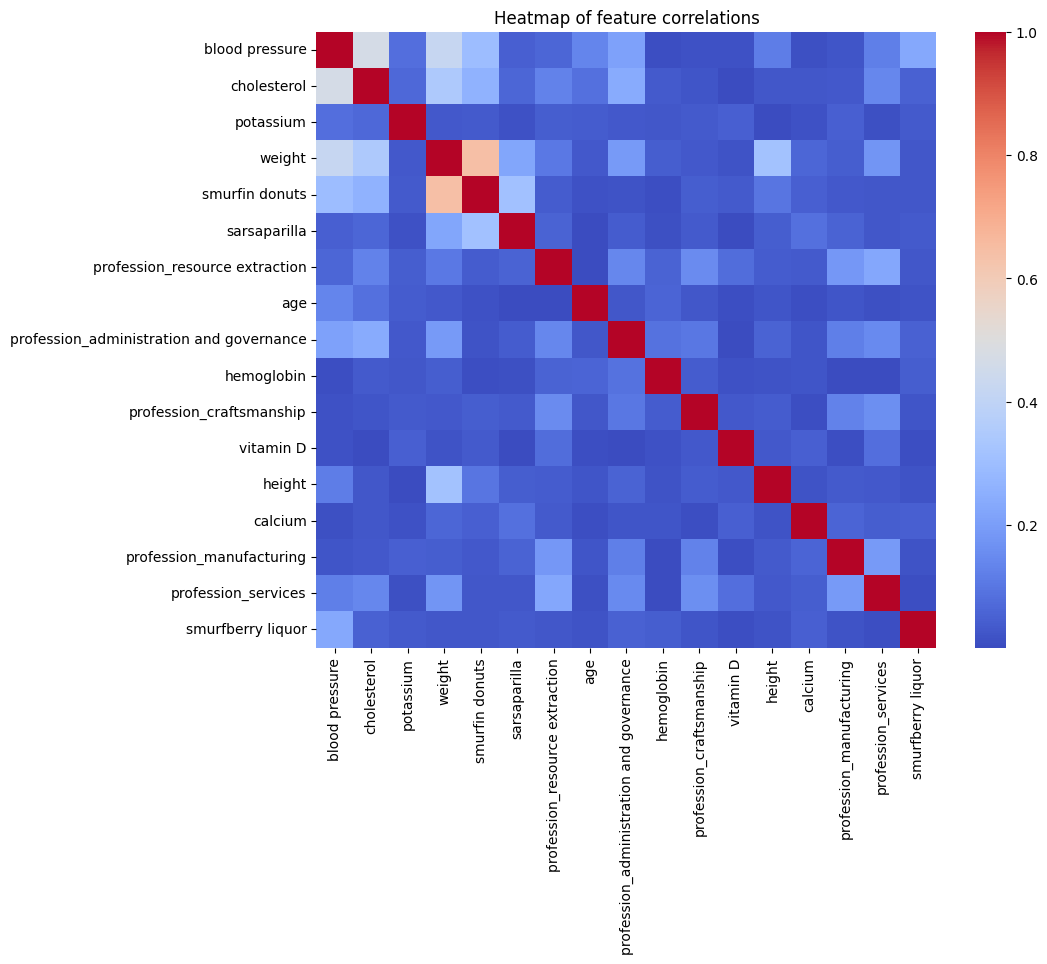


0 variables redondantes supprimées après mRMR simplifié :
[]
17 features restantes après mRMR.


<Figure size 640x480 with 0 Axes>

In [7]:
corr_matrix = X_train_mi.corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Heatmap of feature correlations")
plt.show()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]

X_train_mrmr = X_train_mi.drop(columns=high_corr, errors='ignore')
X_val_mrmr = X_val_mi.drop(columns=high_corr, errors='ignore')
X_test_mrmr = X_test_mi.drop(columns=high_corr, errors='ignore')
X_unlabeled_mrmr = X_unlabeled_mi.drop(columns=high_corr, errors='ignore')
print(f"\n{len(high_corr)} variables redondantes supprimées après mRMR simplifié :")
print(high_corr)
print(f"{X_train_mrmr.shape[1]} features restantes après mRMR.")
plt.tight_layout()
plt.show()

### Embedded method (LASSO CV)

In [8]:
scaler_lasso = StandardScaler()
X_train_scaled = scaler_lasso.fit_transform(X_train_mrmr)

lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train.values.ravel())

coeffs = pd.Series(lasso.coef_, index=X_train_mrmr.columns)
selected_features_lasso = coeffs[coeffs != 0].index.tolist()

print(f"\nFeatures finales retenues par LassoCV ({len(selected_features_lasso)}) :")
print(selected_features_lasso)

X_train_selected = X_train_mrmr[selected_features_lasso]
X_val_selected = X_val_mrmr[selected_features_lasso]
X_test_selected = X_test_mrmr[selected_features_lasso]
X_unlabeled_selected = X_unlabeled_mrmr[selected_features_lasso]


print("Train shape final :", X_train_selected.shape)
print("Validation shape final :", X_val_selected.shape)


Features finales retenues par LassoCV (13) :
['blood pressure', 'cholesterol', 'potassium', 'weight', 'smurfin donuts', 'sarsaparilla', 'profession_resource extraction', 'age', 'profession_administration and governance', 'hemoglobin', 'vitamin D', 'height', 'profession_services']
Train shape final : (800, 13)
Validation shape final : (200, 13)


### Performance comparison 


LinearRegression - RMSE avant sélection : 0.0502
LinearRegression - RMSE après sélection : 0.0503
LassoCV          - RMSE avant sélection : 0.0932
LassoCV          - RMSE après sélection : 0.0936


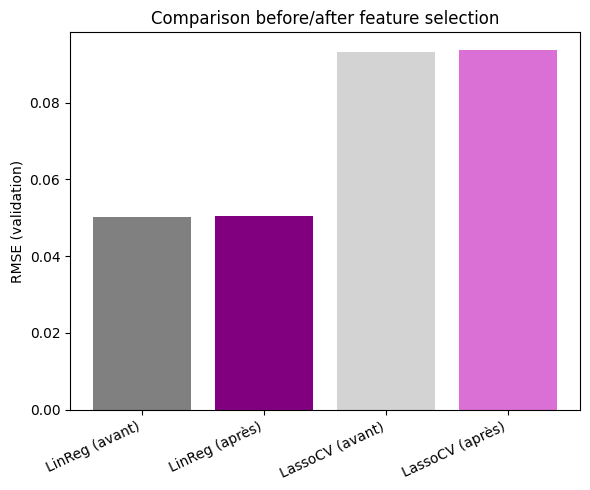

In [9]:
#LinearRegression avant feature selection
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_val_lin_before = linreg.predict(X_val)
rmse_lin_before = compute_rmse(y_pred_val_lin_before, y_val)

#LinearRegression après feature selection
linreg.fit(X_train_selected, y_train)
y_pred_val_lin_after = linreg.predict(X_val_selected)
rmse_lin_after = compute_rmse(y_pred_val_lin_after, y_val)

#LassoCV avant feature selection
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_val_lasso_before = lasso.predict(X_val)
rmse_lasso_before = compute_rmse(y_pred_val_lasso_before, y_val)

# --- D. LassoCV après feature selection ---
lasso.fit(X_train_selected, y_train)
y_pred_val_lasso_after = lasso.predict(X_val_selected)
rmse_lasso_after = compute_rmse(y_pred_val_lasso_after, y_val)

# --- Résultats ---
print(f"\nLinearRegression - RMSE avant sélection : {rmse_lin_before:.4f}")
print(f"LinearRegression - RMSE après sélection : {rmse_lin_after:.4f}")
print(f"LassoCV          - RMSE avant sélection : {rmse_lasso_before:.4f}")
print(f"LassoCV          - RMSE après sélection : {rmse_lasso_after:.4f}")

# --- Visualisation ---
plt.figure(figsize=(6, 5))
labels = ["LinReg (avant)", "LinReg (après)", "LassoCV (avant)", "LassoCV (après)"]
values = [rmse_lin_before, rmse_lin_after, rmse_lasso_before, rmse_lasso_after]
colors = ['gray', 'purple', 'lightgray', 'orchid']

plt.bar(labels, values, color=colors)
plt.ylabel("RMSE (validation)")
plt.title("Comparison before/after feature selection")
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

### Model selection

In [11]:

X_train_full = pd.concat([X_train_mrmr, X_val_mrmr], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

linreg_final = LinearRegression()
linreg_final.fit(X_train_full, y_train_full)

y_pred_test = linreg_final.predict(X_test_mrmr)
rmse_test = compute_rmse(y_pred_test, y_test)
print(f"\nRMSE sur test = {rmse_test:.4f}")

# Prédictions
y_pred_unlabeled = linreg_final.predict(X_unlabeled_mrmr)

y_pred_df = pd.DataFrame(y_pred_unlabeled)
y_pred_df.to_csv("y_pred.csv", index=False, header=False)

print("\nFichier y_pred.csv généré avec succès !")



RMSE sur test = 0.0558

Fichier y_pred.csv généré avec succès !
